In [33]:
%autosave 20
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astroquery.vizier import Vizier

Autosaving every 20 seconds


/opt/conda/lib/python3.6/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Verification reported errors:
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.6/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'SWCREATE' is not FITS standard (invalid value string: 'SkyCam(Linux)      / Name of software that created the image').  Fixed 'SWCREATE' card to meet the FITS standard.
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.6/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Note: astropy.io.fits uses zero-based indexing.

  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.6/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'PROGECT' is not FITS standard (invalid value string: 'MASTER-SAAO').  Fixed 'PROGECT' card to meet the FITS standard.
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.6/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'CUNIT2' is not FITS standard (invalid value

Number of stars: 189
USNO number: 721


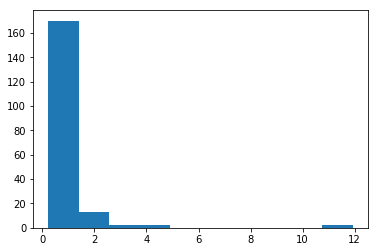

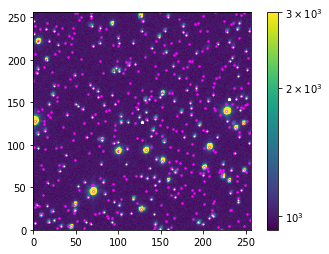

In [56]:
master_fits = fits.open('MASTER.fit')[0]
data = master_fits.data
wcs = WCS(master_fits.header)

mean, median, std = sigma_clipped_stats(data)
star_finder = DAOStarFinder(threshold=5*std, fwhm=3)
pixel_stars = star_finder(data - median)
print('Number of stars: {}'.format(len(pixel_stars)))
x = pixel_stars['xcentroid']
y = pixel_stars['ycentroid']
sky_stars = SkyCoord.from_pixel(x, y, wcs)
center = SkyCoord.from_pixel(data.shape[0] // 2,
                             data.shape[1] // 2,
                             wcs)
upper_left = SkyCoord.from_pixel(0, 0, wcs)
lower_right = SkyCoord.from_pixel(*data.shape, wcs)
diag = lower_right.separation(upper_left)
vizier = Vizier(
    column_filters={},
    row_limit=1000,
)
usno_table = vizier.query_region(
    center,
    radius=diag/2,
    catalog='USNO-A2.0'
)[0]
print('USNO number: {}'.format(len(usno_table)))
usno = SkyCoord(ra=usno_table['RAJ2000'], dec=usno_table['DEJ2000'],
                unit=(u.deg, u.deg))
usno_pixel = usno.to_pixel(wcs)

idx_usno, d2d, _ = sky_stars.match_to_catalog_sky(usno)
plt.hist(d2d.arcsec)
idx_trans = np.where(d2d > 10*u.arcsec)

plt.figure()
plt.imshow(data, origin='lower', norm=LogNorm(vmax=3e3))
plt.xlim([0, data.shape[0]])
plt.ylim([0, data.shape[1]])
plt.plot(*usno_pixel, '.', color='magenta', ms=3)
plt.plot(x, y, '.', color='white', ms=1.5)
plt.plot(x[idx_trans], y[idx_trans],
         color='white', marker='*', ms=3, ls='')
plt.colorbar()